In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return Lane_Detection(image)

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def get_coordinates(Y, lines, prev):
    """
    Calculates the x coordinates for a lane line.
    """
    # print(lines)
    
    '''
    I found below the method of updating current and previous coordinates somewhere online...
    '''
    if lines:
        lines = [line.flatten() for line in lines]
        
        # Calculate line lengths to be used as weights in weighted average
        lengths = [np.sqrt((line[2]-line[0])**2 + (line[3]-line[1])**2) for line in lines]
        
        # Calculate weighted average
        avg = [int(np.average(line, weights = lengths)) for line in zip(*lines)]
        
        # Calculate equation of line coefficients
        coef = np.polyfit((avg[0], avg[2]), (avg[1], avg[3]), 1)
        
        # Average equation of line coefficients with ones from previous frame
        if sum(prev) != 0:
            prev = [(prev[i] + coef[i])/2 for i in range(2)]
        elif sum(prev) == 0:
            prev = [coef[i] for i in range(2)]

    # Calculate x coordinates given y coordinates
    if prev[0]:
        X = [int((y-prev[1])/prev[0]) for y in Y]
    else:
        X = [int(y) for y in Y]

        
    coor = list(zip(X, Y))
    
    return coor, prev
        
def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    global left_prev
    global right_prev
    # sparate lines into left and right lines
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # skip the case where x1==x2
            if not (x2 == x1):
                slope = (y2-y1)/(x2-x1)

                # the origin is the upper left
                # slope < 0, left side
    #             if slope < 0:
    #                 # try to get rid of some noise
                if -2 < slope < -0.5:
                    left_lines.append(line)
                # slope > 0, right side
                if 0 < slope < 2:
                    right_lines.append(line)
    # this may be changed for different cases
    Y = [int(img.shape[0]*0.6), img.shape[0]]
    
    # calculate lines' coordinates for current frame using current & previous frame
    # we just want the bottom and top vertices
    left_coor, left_prev = get_coordinates(Y, left_lines, left_prev)
    right_coor, right_prev = get_coordinates(Y, right_lines, right_prev)
    
    cv2.line(img, (left_coor[0][0], left_coor[0][1]), (left_coor[1][0], left_coor[1][1]), color, thickness)
    cv2.line(img, (right_coor[0][0], right_coor[0][1]), (right_coor[1][0], right_coor[1][1]), color, thickness)
    
    pts = np.array([left_coor[0], left_coor[1], right_coor[1], right_coor[0]], np.int32)
#     pts = pts.reshape((4,1,2))
#     print(pts.shape)
#     cv2.polylines(img, pts, True, (0, 0, 255), thickness=40)
    cv2.fillConvexPoly(img, pts, (51, 255, 51))
    # test


In [5]:

# global variables to store previous frame's points

left_prev = [0, 0]
right_prev = [0, 0]
def Lane_Detection(image):
    global left_prev
    global right_prev
    # reset
    left_prev = [0, 0]
    right_prev = [0, 0]
    # pipeline parameters
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    vertices = np.array([[(0,image.shape[0]),(450, 325), (500, 320), (image.shape[1],image.shape[0])]], dtype=np.int32)
    rho = 2
    theta = np.pi/180
    threshold = 70
    min_line_len = 40
    max_line_gap = 100
    α = 0.9
    β=0.4
    λ=0.
    # grayscale
    gray = grayscale(image)

    # Gaussian blur
    blur = gaussian_blur(gray, kernel_size=kernel_size)
    
    # Canny Edge Detection
    edges = canny(blur, low_threshold=low_threshold, high_threshold=high_threshold)
    
#     plt.imshow(edges, cmap='Greys_r')
#     plt.show()
    # Masked edges
    masked_edges = region_of_interest(edges, vertices)
    
        # Identify lines in image and sort into left and right lines
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)


    # Overlay drawn lines onto original image
    line_edges = weighted_img(line_image, image, α, β, λ)
    return line_edges



In [6]:
white_output = 'test_videos_output/solidWhiteRight_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_test.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_test.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 54.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_test.mp4 

Wall time: 4.55 s


In [23]:
yellow_output = 'test_videos_output/solidYellowLeft_2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:13<00:00, 50.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_2.mp4 

Wall time: 13.9 s


In [24]:
challenge_output = 'test_videos_output/challenge_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_test.mp4
[MoviePy] Writing video test_videos_output/challenge_test.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_test.mp4 

Wall time: 10.5 s


In [10]:
pts = np.array([[100,50],[200,300],[300,200],[500,210]], np.int32)
pts = pts.reshape((-1,1,2))

In [11]:
pts

array([[[100,  50]],

       [[200, 300]],

       [[300, 200]],

       [[500, 210]]])

In [8]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

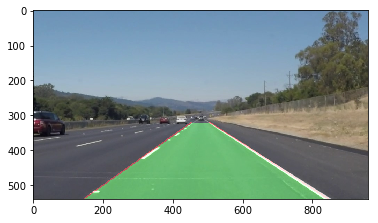

In [9]:
img = np.copy(image)
re = Lane_Detection(img)
plt.imshow(re)

# **Finding Lane Lines on the Road** 


---

**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


[//]: # (Image References)

[image1]: ./assets/result.png

[image2]: ./assets/challenge_with_noise.png


---

### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.


My pipeline consisted of 5 steps:

  * Converte the images to *grayscale*.
  * Apply *Gaussian Blur*.
  * Performe *Canny Edge Detection*.
  * Apply a *mask of interest*.
  * Performe *Hough transformation* and draw the **hough lines**.


    
In order to draw a single line on the left and right lanes, I first included a new helper function **get_coordinates()** and modified the **draw_lines()**:

  1. **get_coordinates()**
  
  First, I was using np.polyfit() to get a line equation to calculate the four vertices I needed. It works well with the first two tasks. But the result for the challenge will be very funny. So I did some research online and used this new method. So the idea is to *first* set the Y coordinates. Then use Y coordinates to calculate X coordinates based on current frame and previous frame. 
  
  This function will return the calculated coordinates (X, Y) and update the previous frame
  
  2. **draw_lines()**
  
  I first separate the *lines* into left_lines and right_lines. And then call get_coordinates() to calculate the coordinates. Then I draw two lines and one filled polygon using the four coordinates.

    

Test on image:


![alt text][image1]


### 2. Identify potential shortcomings with your current pipeline


One potential shortcoming would be what would happen when the image got significant noise (e.g. the challenge). I tried to solve the challenge using my new method of calculating the coordinates. But the result is still not good.  

![alt text][image2]


### 3. Suggest possible improvements to your pipeline

A possible improvement would be to use more advanced computer vision techniques to get rid of noise as I guessed. Some studies mention about techniques of convertting the original image to HSL first before grayscale. I am quite new to computer vision and hopefully I will be equipped with more advanced computer vision techiques soon to get a perfect result for this challenge.
